# Lunar Lander [Pruned]
The objective of this exercise is to land a lunar lander gently on the surface of the moon. The lunar lander environment is provided by [Open AI Gym](https://github.com/openai/gym). The gym environment receives an action and returns a reward value and the new state of the lander. The state of the lander is a 8 dimensional vector with the following components.
* The coordinates of the lander in x & y.
* Its linear velocities in x & y.
* Its angle.
* Its angular velocity.
* Two booleans that represent whether each leg is in contact with the ground or not.

The action is derieved from a set of 4 discrete values:
* 0 (Do nothing)
* 1 (Fire the left orientation engine)
* 2 (Fire the main engine)
* 3 (Fire the right orientation engine)]

The gym environment can receive one action at each timestep.

# References
* [RL using OpenAI Gym](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)
* [Deep Q-Learning](https://github.com/adventuresinML/adventures-in-ml-code/blob/master/r_learning_tensorflow.py)
* [Lunar Lander by vsaveris](https://github.com/vsaveris/lunar-lander-DQN)

In [1]:
%%capture
# Let's start by installing a few required packages. The installation requirements depend on the execution environments.

# Lunar Lander gym environment.
! pip install gym gym[box2d]

# Visualization of the animation.
! pip install ipywidgets

# TF model optimization library for pruning
! pip install tensorflow-model-optimization

In [2]:
%%capture
# simple neural network implementation of qlearning
import gym
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_model_optimization as tfmot

from tensorflow.keras import layers, optimizers, models
from IPython.display import HTML, display
from PIL import Image
from pathlib import Path
from collections import deque
from statistics import mean

## Initialization

/Users/broxoli/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


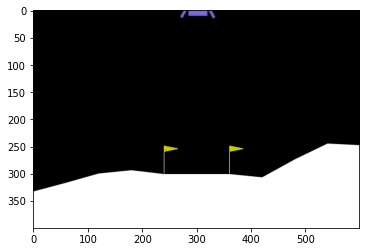

In [3]:
seed = 2341

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For Kaggle
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Lunar Lander environment initialization
env = gym.make("LunarLander-v2")
obs = env.reset()
image = env.render(mode='rgb_array')
plt.imshow(image)

## Lander Model

In [4]:
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n
PRUNING_PARAMS = {
    'enabled': True,
    'max_steps': 1000,
    'initial_sparsity': 0.50,
    'final_sparsity': 0.80
}

def create_pruned_model():
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=PRUNING_PARAMS['initial_sparsity'],
            final_sparsity=PRUNING_PARAMS['final_sparsity'],
            begin_step=0,
            end_step=PRUNING_PARAMS['max_steps']
        )
    }
    return keras.Sequential([
        layers.Input(shape=(N_STATES)),
        tfmot.sparsity.keras.prune_low_magnitude(
            layers.Dense(64, activation="relu"),
            **pruning_params
        ),
        layers.Dense(64, activation="relu"),
        layers.Dense(N_ACTIONS, activation='linear')
    ])

def create_regular_model():
    return keras.Sequential([
        layers.Input(shape=(N_STATES)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(N_ACTIONS, activation='linear')
    ])

def create_model(with_pruning=False):
    """Construct the critic network with q-values per action as output"""
    model = create_pruned_model() if with_pruning else create_regular_model()
    model.compile(optimizer=optimizers.Adam(.001), loss='mse')

    return model

if PRUNING_PARAMS['enabled']:
    print('Pruning is enabled')

model = create_model(with_pruning=PRUNING_PARAMS['enabled'])
model.summary()

Pruning is enabled
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-09-02 15:50:37.408037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-02 15:50:37.408928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/broxoli/miniforge3/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  mask = self.add_variable(
/Users/broxoli/miniforge3/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and wi

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense (  (None, 64)               1090      
 PruneLowMagnitude)                                              
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,510
Trainable params: 4,996
Non-trainable params: 514
_________________________________________________________________


## Training
The training process involves two phases which occur alternatively for each episode. An episode terminates with a successful landing, a crash or the expiration of allowed timesteps (1000 steps). The 'Trainer' collects experience in the first phase by interacting with the gym environment. The model is training in the second phase using the accumulated experiences.

The loss function used in this exercise is the Q Learning Loss function which takes the next state rewards into account for the current state rewards. It's akin to looking one timestep in the future.

In [5]:
GAMMA = .99
DECAY_FACTOR = .99995
BATCH_SIZE = 256
# BATCH_SIZE = 64
MAX_EPISODES = 600
# MAX_EPISODES = 2
ACCEPTABLE_AVERAGE_SCORE_THRESHOLD = 190
MAX_ACCEPTABLE_AVG_SCORE_COUNTER = 100

def Trainer(m, callbacks=[]):
    memory = []
    last_100_scores = deque(maxlen=100)
    epsilon = 1.0
    acceptable_avg_score_counter = 0

    def choosePlay(state):
        nonlocal epsilon
        random_action = lambda: np.random.randint(N_ACTIONS)
    
        def predicted_action():
            q_values = m(tf.expand_dims(state, 0))
            action = tf.squeeze(tf.argmax(q_values, axis=-1))
            return action.numpy()
        
        action =  random_action() if np.random.random() <= epsilon else predicted_action()
        epsilon *= DECAY_FACTOR

        return action
    
    def obs_to_state(obs):
        state = np.squeeze(obs)
        return state

    def play(state):
        action = choosePlay(state)
        obs, reward, done, _ = env.step(action)
        new_state = obs_to_state(obs)

        return action, reward, new_state, done
    
    def train_step(state):
        # Play to gain experience
        action, reward, new_state, done = play(state)
        new_state = np.zeros_like(state) if done else new_state

        # Store experience in the memory bank
        memory.append((state, action, reward, new_state))

        # Train the network with a batch of the gained experience
        batch = np.asarray(random.sample(memory, min(len(memory), BATCH_SIZE)), dtype=object)
        q_s_a = m.predict(np.stack(batch[:, 0], axis = 0))  #Q(s,a)   
        q_s_a_next = m.predict(np.stack(batch[:, 3], axis = 0))  #Q(s',a)

        for item_id in range(batch.shape[0]):
            if np.array_equal(batch[item_id, 3], np.zeros(N_STATES)):
                q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2]
            else:
                q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2] + GAMMA*np.amax(q_s_a_next[item_id, :])

        m.fit(np.stack(batch[:, 0], axis = 0), q_s_a, batch_size=BATCH_SIZE, verbose=0, callbacks=callbacks)
        
        return new_state, reward, done
    
    def record_episode(episode_id, step_id, score, reward, results):
        nonlocal acceptable_avg_score_counter

        # Update the last 100 scores queue with the latest score
        last_100_scores.append(score)

        # Collect episode results
        mean_last_100_scores = mean(last_100_scores)
        results.append((step_id, reward, score, mean_last_100_scores))
        
        # Increment the counter if the episode scores past the acceptance threshold
        # Reset the counter if the episode falls below the acceptance threshold
        if mean_last_100_scores > ACCEPTABLE_AVERAGE_SCORE_THRESHOLD:
            acceptable_avg_score_counter += 1
        else:
            acceptable_avg_score_counter = 0

        print(
            'Episode:', episode_id,
            'Steps:', step_id,
            'Score:', score,
            '100_rolling_average:', mean_last_100_scores,
            'Acceptable Average Score Count:', acceptable_avg_score_counter,
        )

    def train(episodes=MAX_EPISODES, steps=1000):
        results = []

        for episode_id in range(episodes):
            obs = env.reset()
            state = obs_to_state(obs)
            score = 0

            for step_id in range(steps):
                state, reward, done = train_step(state)
                score += reward
                
                if done:
                    record_episode(episode_id, step_id, score, reward, results)
                    break
            
            # Terminate training if the average score meet the acceptance threshold
            # for MAX_ACCEPTABLE_AVG_SCORE_COUNTER episodes in sequence.
            if acceptable_avg_score_counter >= MAX_ACCEPTABLE_AVG_SCORE_COUNTER:
                break

        return results
    
    return train

# Add a pruning callback for training with pruning.
pruning_cb = tfmot.sparsity.keras.UpdatePruningStep()
callbacks = (PRUNING_PARAMS['enabled'] and [pruning_cb]) or []
    
trainer = Trainer(model, callbacks=callbacks)
results = trainer()
# results = trainer(steps=700)

with open('lunar_lander.results.pkl', 'wb') as f:
    pickle.dump(results, f)
    
strip_pruning = tfmot.sparsity.keras.strip_pruning
lunar_lander = (PRUNING_PARAMS['enabled'] and strip_pruning(model)) or model
# stripped_model.save_weights('lunar_lander.h5')

# Save the trained model
models.save_model(lunar_lander, 'lunar_lander.h5', include_optimizer=False)

2022-08-31 13:25:38.646581: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Episode: 0 Steps: 60 Score: -116.13953519751135 100_rolling_average: -116.13953519751135 Acceptable Average Score Count: 0
Episode: 1 Steps: 89 Score: -115.73746078033965 100_rolling_average: -115.93849798892549 Acceptable Average Score Count: 0
Episode: 2 Steps: 105 Score: -483.3184357216811 100_rolling_average: -238.39847723317737 Acceptable Average Score Count: 0
Episode: 3 Steps: 92 Score: -216.2854813701279 100_rolling_average: -232.870228267415 Acceptable Average Score Count: 0
Episode: 4 Steps: 64 Score: -74.07522786986088 100_rolling_average: -201.11122818790417 Acceptable Average Score Count: 0
Episode: 5 Steps: 98 Score: -124.96279175551949 100_rolling_average: -188.41982211584008 Acceptable Average Score Count: 0
Episode: 6 Steps: 85 Score: -438.2923375158665 100_rolling_average: -224.11589574441527 Acceptable Average Score Count: 0
Episode: 7 Steps: 72 Score: -235.38238326444122 100_rolling_average: -225.52420668441852 Acceptable Average Score Count: 0
Episode: 8 Steps: 101

## Training Summary

Label(value='Training Results')

,Steps,Reward,Score,R100_Score,Done,Crashed
0,60,-100.00000,-116.139535,-116.139535,False,True
1,89,-100.00000,-115.737461,-115.938498,False,True
2,105,-100.00000,-483.318436,-238.398477,False,True
3,92,-100.00000,-216.285481,-232.870228,False,True
4,64,-100.00000,-74.075228,-201.111228,False,True
...,...,...,...,...,...,...
398,356,100.00000,258.915558,227.187333,True,False
399,298,100.00000,278.779180,227.520696,True,False
400,322,100.00000,273.424722,227.690350,True,False
401,999,0.14854,100.812962,226.095427,False,False


Successes: 223 Crashes: 158 Timeouts: 22


Label(value='Top Scores')

,Steps,Reward,Score,R100_Score,Done,Crashed
188,556,100.0,300.384327,-21.752037,True,False
367,335,100.0,295.491270,219.306800,True,False
168,302,100.0,291.731454,-78.436652,True,False
318,332,100.0,287.121491,208.576472,True,False
358,398,100.0,287.034879,217.257157,True,False


Label(value='Bottom Scores')

,Steps,Reward,Score,R100_Score,Done,Crashed
17,103,-100.0,-348.128191,-196.244008,False,True
128,962,-100.0,-358.013152,-111.265882,False,True
61,151,-100.0,-383.394824,-153.133658,False,True
6,85,-100.0,-438.292338,-224.115896,False,True
2,105,-100.0,-483.318436,-238.398477,False,True


Label(value='Training Benchmarks')

,Start,End,Count,Successes,Crashes,Timeouts
0,0,200,116,0,116,0
1,200,300,31,14,17,0
2,300,500,130,122,8,0
3,500,700,68,60,8,0
4,700,1000,58,27,9,22


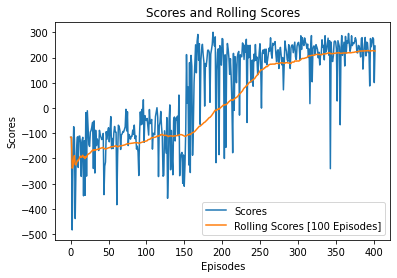

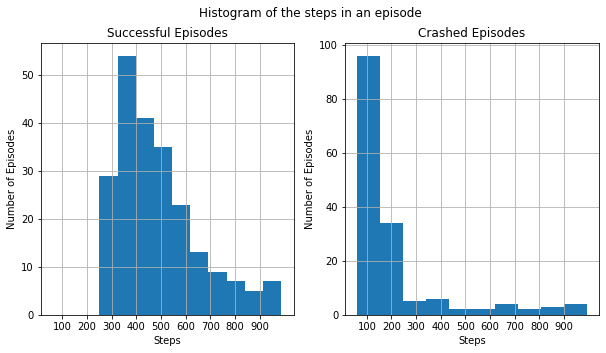

In [6]:
from ipywidgets import Label

def load_results(file):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        columns = ['Steps', 'Reward', 'Score', 'R100_Score']
        return pd.DataFrame(results, columns=columns)

def show_results(df):
    df['Done'] = df['Reward'] == 100
    df['Crashed'] = df['Reward'] == -100

    # Plot rolling scores
    plt.plot(df['Score'], label='Scores')
    plt.plot(df['R100_Score'], label='Rolling Scores [100 Episodes]')
    plt.legend()
    plt.title('Scores and Rolling Scores')
    plt.xlabel('Episodes')
    plt.ylabel('Scores')

    display(Label('Training Results'), df)

def summarize_results(file):
    df = load_results(file)
    show_results(df)

    # Display Summary
    successes = len(df[df['Done'] == True])
    crashes = len(df[df['Crashed'] == True])
    timeouts = len(df.loc[(df['Crashed'] == False) & (df['Done'] == False)])
    print('Successes:', successes, 'Crashes:', crashes, 'Timeouts:', timeouts)

    # Top and bottom scores
    sorted_scores = df.sort_values('Score', ascending=False)
    display(Label('Top Scores'), sorted_scores.head())
    display(Label('Bottom Scores'), sorted_scores.tail())
    
    steps_benchmarks = [0, 200, 300, 500, 700, 1000]
    benchmark_df = pd.DataFrame(columns=['Start', 'End', 'Count', 'Successes', 'Crashes', 'Timeouts'])

    for bm in range(1, len(steps_benchmarks)):
        start, end = steps_benchmarks[bm - 1], steps_benchmarks[bm]
        range_cond = (df['Steps']>=start) & (df['Steps']<end)

        count = len(df.loc[range_cond])
        successes = len(df.loc[range_cond & df['Done'] == True])
        crashes = len(df.loc[range_cond & df['Crashed'] == True])
        timeouts = len(df.loc[range_cond & (df['Crashed'] == False) & (df['Done'] == False)])

        benchmark_df.loc[bm-1] = (start, end, count, successes, crashes, timeouts)
    
    # Training Benchmarks
    display(Label('Training Benchmarks'), benchmark_df)

    # Episode Steps Histogram
    successes_df = df.loc[df['Done'] == True]['Steps']
    crashes_df = df.loc[df['Crashed'] == True]['Steps']

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
    successes_df.hist(ax=axes[0])
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Number of Episodes')
    axes[0].set_title('Successful Episodes')
    axes[0].set_xticks(range(0, 1000, 100))

    crashes_df.hist(ax=axes[1])
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Number of Episodes')
    axes[1].set_title('Crashed Episodes')
    fig.suptitle('Histogram of the steps in an episode')

# summarize_results('v23/lunar_lander.results.pkl')
summarize_results('lunar_lander.results.pkl')

In [31]:
import numpy as np
import ipywidgets as ipyw

def get_block_sparsity(block, weight_id):
    # Get block conv layer weights
    weights = block.weights[weight_id].numpy()
    non_zeros = np.count_nonzero(weights)
    total = weights.size
    zeros = total - non_zeros
    sparsity = (zeros/total)*100

    return (sparsity, total)

def display_model_sparsity(m, layer_ids=[], title='Post-training sparsity'):
    display(ipyw.Label(title))
    for layer_id in layer_ids:
        sparsity, total = get_block_sparsity(m, layer_id)
        print('Block: {} Sparsity: {}% Total Weights: {}'.format(m.layers[layer_id].name, sparsity, total))

display_model_sparsity(lunar_lander, [0, 1, 2], 'Sparse Model post-training layerwise sparsity.')

Label(value='Sparse Model post-training layerwise sparsity.')

Block: dense Sparsity: 80.078125% Total Weights: 512
Block: dense_1 Sparsity: 0.0% Total Weights: 64
Block: dense_2 Sparsity: 0.0% Total Weights: 4096


## Trial Run

In [32]:
def save_visuals(env, frames):
    # Save the current game visuals
    frame = env.render(mode='rgb_array')
    frames.append(frame)

def save_frames_as_gif(container, episode_id, frames):
    gif = Image.fromarray(np.copy(frames[0]))
       
    gif_name = 'lunar_lander.{}.{}.gif'.format(episode_id, random.randint(0,2e9))

    gif.save(
        gif_name,
        append_images=list(map(lambda im: Image.fromarray(im), frames[1:])),
        save_all=True, duration=5, loop=0
    )

    container[episode_id] = gif_name

def trial_run(m):
    def obs_to_state(obs):
        state = np.squeeze(obs)
        return state
    
    def predicted_action(state):
        q_values = m(tf.expand_dims(state, 0))
        action = tf.squeeze(tf.argmax(q_values, axis=-1))
        return action.numpy()

    obs = env.reset()
    score = 0
    frames = []

    for step_id in range(1000):
        state = obs_to_state(obs)
        action = predicted_action(state)
        obs, reward, done, _ = env.step(action)
        score += reward
        
        # Save visuals
        save_visuals(env, frames)

        if done:
            print('Finished with total score:', score, 'in steps: ', step_id)
            break
    
    print('Total Score:', score, 'Done:', done)
    return frames

container, frames = {}, trial_run(lunar_lander)
save_frames_as_gif(container, 0, frames)

Finished with total score: 306.74444440310265 in steps:  245
Total Score: 306.74444440310265 Done: True


## Animation Visualization

In [33]:
import ipywidgets as ipyw

def create_expanded_button(description, button_style):
    return ipyw.Button(description=description, button_style=button_style, layout=ipyw.Layout(height='auto', width='auto'))

def image_widget(file):
    with open(file, "rb") as file:
        image = file.read()
        # return Image(value=image, width=w, height=h)
        return ipyw.Image(value=image)

def image_label_widget(title, file):
    image = image_widget(file)
    label = ipyw.Label(value=title)
    layout = ipyw.Layout(display='flex', flex_flow='column', align_items='stretch', border='solid')
    box = ipyw.Box(children=[image, label], layout=layout)
    return box

def display_gifs_grid(images, cols=5):
    rows = (len(images)+cols-1) // cols
    grid = ipyw.GridspecLayout(rows, cols)

    for index, image in images.items():
        gcol = index%cols
        grow = index//cols

        grid[grow, gcol] = image_label_widget(str(index), image)
    
    return grid

display_gifs_grid(container, cols=1)


GridspecLayout(children=(Box(children=(Image(value=b'GIF89aX\x02\x90\x01\x87\x00\x00\xff\xff\xff\xfc\xfc\xfc\x…

<img src='./lunar_lander.0.682162121.gif'>